#Imports/Permissions to load data

In [ ]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

#stuff we need
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from tensorflow.keras.utils import get_custom_objects
from google.colab import drive
import h5py
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Reshape, Dropout, BatchNormalization
from keras.optimizers import SGD
from sklearn.model_selection import train_test_split
import pickle


# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

drive.mount('/content/drive')

Mounted at /content/drive


#Data Scaling

In [ ]:
x_val, y_val=np.empty([0, 110006]), np.empty([0, 6])
filepath='./drive/Shareddrives/ML_project/Complete_Spectral_Data/Training_Data/finished_data0'

allfiles, testfiles=np.arange(100), np.arange(0, 100, 10)
trainmask=[False if num in testfiles else True for num in allfiles]
trainfiles=shuffle(allfiles[trainmask], random_state=0)
pickle.dump(trainfiles, open('fileorder', 'wb'))

sc_x, sc_y=StandardScaler(), StandardScaler()

#This loading function is annoying and perhaps overly complicated, but basically, when preparing the data we accidentally left it in order of 
#stellar circularity fraction. So now we load 10 random files at a time, combine their entries, and randomly select part of our validation data 
#from this.
for i in range(0, 90, 5):
  x_chunk, y_chunk=np.empty([0, 110006]), np.empty([0, 6])
  for file in trainfiles[i:i+5]:
    file_obj=h5py.File(filepath+str(file)+'.hdf5', 'r')
    x, y=file_obj['Data']['x_values'], file_obj['Data']['y_values']
    x_chunk, y_chunk=np.concatenate((x_chunk, x)), np.concatenate((y_chunk, y))
#Here we have the x and y values from 10 files. Now we add 10% of this to the total validation data and fit the scaler to the training data
  x_train, xv, y_train, yv=train_test_split(x_chunk, y_chunk, test_size=0.1, random_state=0)  #train_test_split also shuffles data
  print(x_train[0])
  x_val, y_val=np.concatenate((x_val, xv)), np.concatenate((y_val, yv))
  sc_x.partial_fit(x_train)
  sc_y.partial_fit(y_train)
pickle.dump(x_val, open('x_validation_set', 'wb'))
pickle.dump(y_val, open('y_validation_set', 'wb'))

[ 0.56628677  0.66604666  0.75693083 ... 13.56096257 16.89196968
  0.2314319 ]
[ 0.5847448   0.67160022  0.82162209 ... 17.52517273 20.68264961
  0.44186667]
[ 0.45313741  0.71730856  0.73102454 ... 13.13332152 13.0045414
  0.11616548]
[ 0.58008255  0.77330704  0.80450852 ... 13.61432757  7.32924223
  0.17225046]
[0.59253356 0.5552796  0.69122495 ... 9.14400114 4.4026556  0.23186919]
[ 0.58506834  0.6793818   0.69125429 ... 11.26773477  5.54868221
  0.16757575]
[ 0.63229526  0.59794513  0.73006858 ... 13.98455885 12.25931644
  0.13214485]
[ 0.59524702  0.73677218  0.76594969 ... 11.32743539 11.98823452
  0.12544258]
[ 0.54559037  0.65665553  0.80609247 ...  7.31536362 10.22397518
  0.23103327]
[ 0.48898824  0.68359414  0.69441969 ... 18.83290301 11.91924572
  0.22534336]
[ 0.52425095  0.70919871  0.73450189 ... 10.31333755  8.83122826
  0.22863434]
[ 0.59269538  0.67399404  0.70238021 ... 17.31536354  7.85384178
  0.17038868]
[ 0.60039626  0.65984919  0.71894807 ... 15.95295827  7.5906

#Train/Load Autoencoder

We train our auto-encoder and final model using mini-batches. After each minibatch, we save the autoencoder. This allows us to resume training manually after disconnects. When we finally train our model we simply load the autoencoder. 

In [ ]:
#LeakyReLU definition and autoencoder initialization
def leaky_relu(z,name=None):
  return tf.maximum(0.01*z, z, name=name)
get_custom_objects().update({'leaky_relu':leaky_relu})
stacked_encoder = Sequential()
#stacked_encoder.add(Dense(300,input_dim=N, activation=leaky_relu))
stacked_encoder.add(Dense(250,input_dim=len(x_train[0]), activation='leaky_relu'))
stacked_encoder.add(BatchNormalization())
stacked_encoder.add(Dense(40, activation='linear'))
stacked_encoder.add(BatchNormalization())

stacked_decoder = Sequential()
stacked_decoder.add(Dense(250,activation='leaky_relu',input_shape=[40]))
stacked_decoder.add(BatchNormalization())
#stacked_decoder.add(Dense(300,activation=leaky_relu,input_shape=[100]))
stacked_decoder.add(Dense(len(x_train[0]),activation='sigmoid'))
stacked_decoder.add(BatchNormalization())
stacked_ae = Sequential([stacked_encoder,stacked_decoder])
stacked_ae.compile(loss='mean_squared_error', optimizer= SGD(lr=0.01, momentum = 0.95)) # changed lr from 0.01 to 0.001 

In [ ]:
#Autoencoder training
trainfiles=pickle.load(open('fileorder', 'rb'))
for i in range(0, 90, 5): # loading 10 files at a time 
  x_chunk, y_chunk=np.empty([0, 110006]), np.empty([0, 6])
  for file in trainfiles[i:i+5]:
    file_obj=h5py.File(filepath+str(file)+'.hdf5', 'r')
    x, y=file_obj['Data']['x_values'], file_obj['Data']['y_values']
    x_chunk, y_chunk=np.concatenate((x_chunk, x)), np.concatenate((y_chunk, y))
#Here we have the x and y values from 10 files. Now we add 10% of this to the total validation data and fit the scaler to the training data
  x_train, xv, y_train, yv=train_test_split(x_chunk, y_chunk, test_size=0.1, random_state=0)  #train_test_split also shuffles data
  x_train_scaled=sc_x.transform(x_train)
  history=stacked_ae.fit(x_train_scaled, x_train_scaled, epochs=30, batch_size=32, verbose=2)
  stacked_ae.save('autoencoder.h5')
  print(i+5)
stacked_encoder.save('encoder.h5')
#Because our auto-encoder doesn't have a variable learning rate, we can just train it on one chunk at a time as though each were a whole dataset


#stacked_ae=keras.models.load_model('autoencoder.h5')
#encoder=keras.models.load_model('encoder.h5')

Epoch 1/30
19/19 - 10s - loss: 1.2315
Epoch 2/30
19/19 - 9s - loss: 1.2193
Epoch 3/30
19/19 - 9s - loss: 1.1993
Epoch 4/30
19/19 - 9s - loss: 1.1731
Epoch 5/30
19/19 - 9s - loss: 1.1407
Epoch 6/30
19/19 - 9s - loss: 1.1069
Epoch 7/30
19/19 - 9s - loss: 1.0755
Epoch 8/30
19/19 - 9s - loss: 1.0478
Epoch 9/30
19/19 - 9s - loss: 1.0247
Epoch 10/30
19/19 - 9s - loss: 1.0094
Epoch 11/30
19/19 - 8s - loss: 0.9973
Epoch 12/30
19/19 - 9s - loss: 0.9895
Epoch 13/30
19/19 - 14s - loss: 0.9804
Epoch 14/30
19/19 - 9s - loss: 0.9791
Epoch 15/30
19/19 - 9s - loss: 0.9730
Epoch 16/30
19/19 - 9s - loss: 0.9676
Epoch 17/30
19/19 - 9s - loss: 0.9687
Epoch 18/30
19/19 - 9s - loss: 0.9640
Epoch 19/30
19/19 - 9s - loss: 0.9638
Epoch 20/30
19/19 - 9s - loss: 0.9570
Epoch 21/30
19/19 - 8s - loss: 0.9593
Epoch 22/30
19/19 - 9s - loss: 0.9571
Epoch 23/30
19/19 - 9s - loss: 0.9558
Epoch 24/30
19/19 - 9s - loss: 0.9533
Epoch 25/30
19/19 - 9s - loss: 0.9484
Epoch 26/30
19/19 - 9s - loss: 0.9493
Epoch 27/30
19/19 -

#Defining/Training Model

In [ ]:
ae_nn = Sequential([stacked_encoder])
ae_nn.add(BatchNormalization())
ae_nn.add((Dropout(.2)))
ae_nn.add(Dense(6,activation='linear'))
ae_nn.compile(loss='mean_squared_error', optimizer=SGD(lr=0.01, momentum = 0.95))

trainfiles=pickle.load(open('fileorder', 'rb'))
for i in range(0, 90, 5):
  x_chunk, y_chunk=np.empty([0, 110006]), np.empty([0, 6])
  for file in trainfiles[i:i+5]:
    file_obj=h5py.File(filepath+str(file)+'.hdf5', 'r')
    x, y=file_obj['Data']['x_values'], file_obj['Data']['y_values']
    x_chunk, y_chunk=np.concatenate((x_chunk, x)), np.concatenate((y_chunk, y))
#Here we have the x and y values from 10 files. Now we add 10% of this to the total validation data and fit the scaler to the training data
  x_train, xv, y_train, yv=train_test_split(x_chunk, y_chunk, test_size=0.1, random_state=0)  #train_test_split also shuffles data
  x_train_scaled, y_train_scaled=sc_x.transform(x_train), sc_y.transform(y_train)
  history = ae_nn.fit(x_train_scaled, y_train_scaled, epochs=70, batch_size=32, verbose=2)
  ae_nn.save('ae_nn.h5')
  print(i+5)
ae_nn.save('ae_nn.h5')

#ae_nn=keras.models.load_model('ae_nn.h5')

Epoch 1/70
19/19 - 4s - loss: 1.4757
Epoch 2/70
19/19 - 2s - loss: 0.8078
Epoch 3/70
19/19 - 3s - loss: 0.5371
Epoch 4/70
19/19 - 3s - loss: 0.3923
Epoch 5/70
19/19 - 3s - loss: 0.4738
Epoch 6/70
19/19 - 3s - loss: 0.3186
Epoch 7/70
19/19 - 3s - loss: 0.3897
Epoch 8/70
19/19 - 3s - loss: 0.2686
Epoch 9/70
19/19 - 3s - loss: 0.2418
Epoch 10/70
19/19 - 3s - loss: 0.2391
Epoch 11/70
19/19 - 3s - loss: 0.2099
Epoch 12/70
19/19 - 3s - loss: 0.2077
Epoch 13/70
19/19 - 3s - loss: 0.2043
Epoch 14/70
19/19 - 3s - loss: 0.1710
Epoch 15/70
19/19 - 3s - loss: 0.1381
Epoch 16/70
19/19 - 3s - loss: 0.1801
Epoch 17/70
19/19 - 3s - loss: 0.2003
Epoch 18/70
19/19 - 3s - loss: 0.1972
Epoch 19/70
19/19 - 3s - loss: 0.1919
Epoch 20/70
19/19 - 3s - loss: 0.1767
Epoch 21/70
19/19 - 3s - loss: 0.1632
Epoch 22/70
19/19 - 3s - loss: 0.1507
Epoch 23/70
19/19 - 3s - loss: 0.1438
Epoch 24/70
19/19 - 3s - loss: 0.1918
Epoch 25/70
19/19 - 3s - loss: 0.1571
Epoch 26/70
19/19 - 3s - loss: 0.1385
Epoch 27/70
19/19 - 3

#Validating the Model

In [6]:
x_val, y_val=pickle.load(open('x_validation_set', 'rb')), pickle.load(open('y_validation_set', 'rb'))
x_val_scaled, y_val_scaled=sc_x.transform(x_val), sc_y.transform(y_val)
results = ae_nn.evaluate(x_val_scaled, y_val_scaled, batch_size=32)
print("test loss:", results)
ae_nn_test_sc = sc_y.inverse_transform(ae_nn.predict(x_val_scaled))

39/39 [==============================] - 3s 55ms/step - loss: 0.1081
test loss: 0.10805638879537582


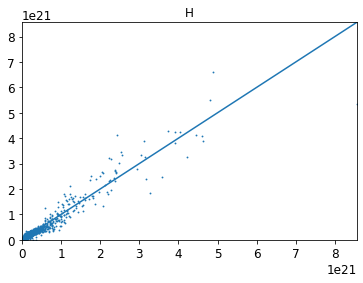

<Figure size 432x288 with 0 Axes>

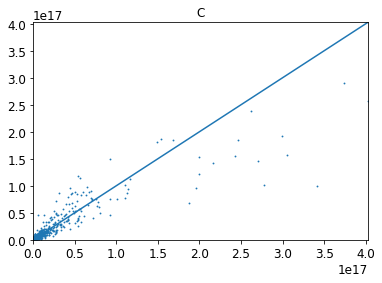

<Figure size 432x288 with 0 Axes>

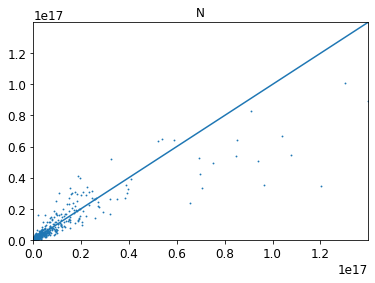

<Figure size 432x288 with 0 Axes>

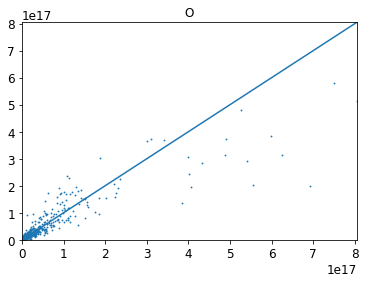

<Figure size 432x288 with 0 Axes>

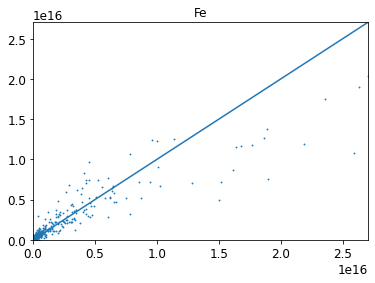

<Figure size 432x288 with 0 Axes>

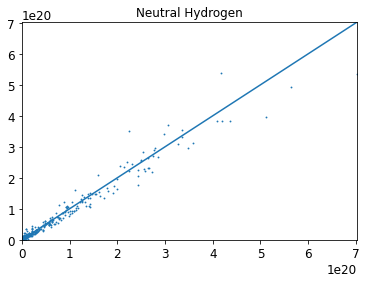

<Figure size 432x288 with 0 Axes>

In [7]:
CDs=['H', 'C', 'N', 'O', 'Fe', 'Neutral Hydrogen']
for i in range(6):
  fig=plt.figure()
  ax=fig.add_subplot(111)
  axis_limit=max(max(y_val[:, i]), max(ae_nn_test_sc[:, i]))
  ax.set_xlim([0, axis_limit])
  ax.set_ylim([0, axis_limit])
  ax.set_title(CDs[i])
  plt.scatter(y_val[:,i], ae_nn_test_sc[:,i], s=0.7)
  plt.plot(np.linspace(0., axis_limit), np.linspace(0., axis_limit))
  plt.show()
  plt.clf()